### Importing required libraries

In [1]:
import pandas as pd
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn import CrossEntropyLoss
from makeDataset import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../datasets/sentiment_dataset.csv',
                names=['sentiment', 'text'],
                encoding='utf-8', encoding_errors='replace')

In [3]:
df.head(5)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


### Depicting the number of each sentiment in the dataset

<Axes: xlabel='Sentiment', ylabel='Count'>

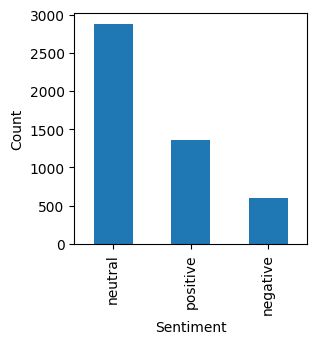

In [4]:
df.value_counts('sentiment').plot(kind='bar', 
                figsize=(3, 3), xlabel='Sentiment', ylabel='Count')

### Preprocessing the dataset, using transfer learning to import Finbert model, and introducing the hyperparameters for training the Finbert model

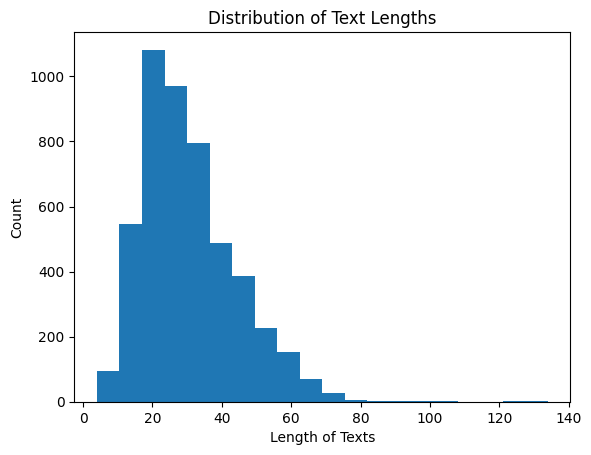

In [5]:
# Create a copy of the dataframe (to avoid modifying the original dataframe)
data_df = df.copy(deep=True)
# Preprocess your data
le = LabelEncoder()
data_df['sentiment_encoded'] = le.fit_transform(data_df['sentiment'])
device = torch.device('cuda')

# Split the data into train and validation sets
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone', do_lower_case=True)
# finding the length of texts to set the max length of the encoder
len_of_texts = []
for text in df['text']:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    len_of_texts.append(len(input_ids))
import matplotlib.pyplot as plt

plt.hist(len_of_texts, bins=20)
plt.xlabel('Length of Texts')
plt.ylabel('Count')
plt.title('Distribution of Text Lengths')
plt.show()

#### Based on this distribution of lengths it is better to select 80 as the max_length

In [14]:
# Declare the number of labels (neutral, positive, negative)
num_labels = 3
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
model = model.to(device)
max_len = 80

# Define training parameters
batch_size = 16
epochs = 5
lr = 2e-5

# Create dataloaders
train_dataset = CustomDataset(train_df['text'], train_df['sentiment_encoded'], tokenizer, max_len=max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_df['text'], val_df['sentiment_encoded'], tokenizer, max_len=max_len)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=lr)
loss_fn = CrossEntropyLoss()


### Training the finbert model 

In [108]:
max_val_accuracy = -1
# Training loop
train_accuracy_list = []
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    correct_preds = 0
    total_preds = 0
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        
        loss.backward()        
        optimizer.step()
        
        _, predicted = torch.max(outputs.logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_accuracy = correct_preds / total_preds
    train_accuracy_list.append(train_accuracy)
    avg_train_loss = train_loss / len(train_loader)
    print(f'Training Loss: {avg_train_loss:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_preds / total_preds
    
    if max_val_accuracy < val_accuracy:
        max_val_accuracy = val_accuracy
        model.save_pretrained("../finbert_finetuned")
    
    print(f'Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')

# Save the fine-tuned model
# load the saved model
# model = BertForSequenceClassification.from_pretrained("../finbert_finetuned")

Training Loss: 0.9226
Validation Loss: 0.4273 | Validation Accuracy: 0.8258


Training Loss: 0.3431
Validation Loss: 0.5125 | Validation Accuracy: 0.8299


Training Loss: 0.1648
Validation Loss: 0.5246 | Validation Accuracy: 0.8464
